### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [3]:
df_customer = pd.read_csv('df_customer').iloc[:, 1:]
df_product = pd.read_csv('df_product').iloc[:, 1:]
df_purchase = pd.read_csv('df_purchase').iloc[:, 1:]

In [4]:
list_status_bar = [2, 3, 5, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 27, 28, 32, 35, 39, 40, 45, 46]
df_customer['is_bar'] = df_customer['status_id'].isin(list_status_bar)

In [5]:
df = df_purchase[['amount', 'customer_id', 'product_id']].merge(df_customer[['id', 'nickname', 'year', 'is_bar']], how='left', left_on='customer_id', right_on='id').drop('id', axis=1)
df = df.merge(df_product[['id', 'name']], how='left', left_on='product_id', right_on='id').drop('id', axis=1)[['product_id', 'name', 'amount', 'customer_id', 'nickname', 'year', 'is_bar']]

### Short analysis

In [8]:
cust = df_customer.groupby('year').agg({'id' : 'count'})
prod = df_product.groupby('price').agg({'id' : 'count'}).reset_index()

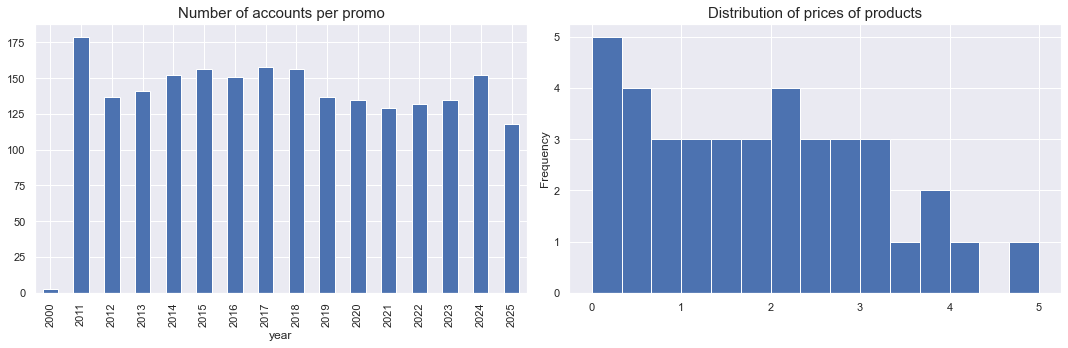

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

cust['id'].plot(kind='bar', ax=ax1)
ax1.set_title('Number of accounts per promo', fontsize = 15)

prod.loc[(prod.price >= 0) & (prod.price <= 5), 'price'].plot(kind='hist', ax=ax2, bins = 15)
ax2.set_title('Distribution of prices of products', fontsize = 15)

plt.tight_layout()
plt.show()

### Rankings

In [12]:
df.tail(3)

,product_id,name,amount,customer_id,nickname,year,is_bar
172369,222,San Miguel,2.0,2075,Salade,2025,False
172370,222,San Miguel,2.0,2075,Salade,2025,False
172371,287,La Barge DDH IPA,2.5,2044,Mali,2024,False


In [13]:
df_ranking_product = df.groupby('name').agg({'amount' : 'sum'}).sort_values(by=['amount'])
df_ranking_customer = df.groupby('nickname').agg({'amount' : 'sum'}).sort_values(by=['amount'])
df_ranking_promo = df.groupby(['year', 'is_bar']).agg({'amount' : 'sum'})

df_ranking_product_count = df.groupby('name').agg({'amount' : 'count'}).sort_values(by=['amount'])
df_ranking_customer_count = df.groupby('nickname').agg({'amount' : 'count'}).sort_values(by=['amount'])
df_ranking_promo_count = df.groupby(['year', 'is_bar']).agg({'amount' : 'sum'})

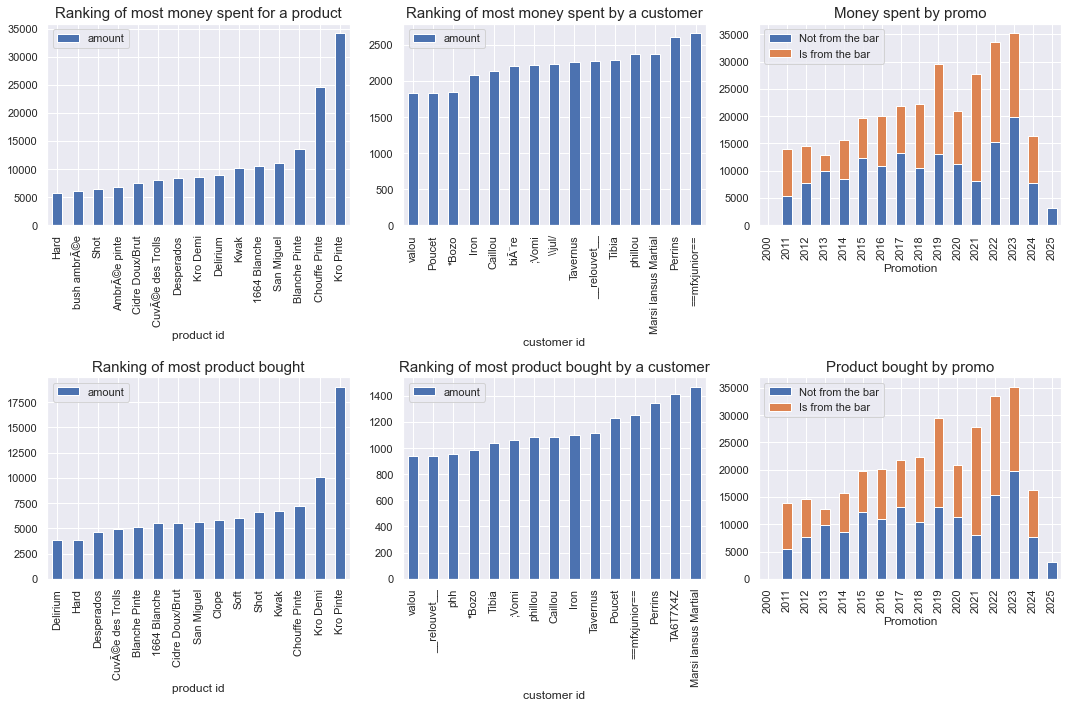

In [24]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

df_ranking_product[-15:].plot(kind='bar', ax=ax1)
ax1.set_title('Ranking of most money spent for a product', fontsize = 15)
ax1.set_xlabel('product id')

df_ranking_customer[-15:].plot(kind='bar', ax=ax2)
ax2.set_title('Ranking of most money spent by a customer', fontsize = 15)
ax2.set_xlabel('customer id')

df_ranking_promo.unstack().plot(kind='bar', stacked=True, ax=ax3)
ax3.legend(["Not from the bar", "Is from the bar"]);
ax3.set_title('Money spent by promo', fontsize = 15)
ax3.set_xlabel('Promotion')

df_ranking_product_count[-15:].plot(kind='bar', ax=ax4)
ax4.set_title('Ranking of most product bought', fontsize = 15)
ax4.set_xlabel('product id')

df_ranking_customer_count[-15:].plot(kind='bar', ax=ax5)
ax5.set_title('Ranking of most product bought by a customer', fontsize = 15)
ax5.set_xlabel('customer id')

df_ranking_promo_count.unstack().plot(kind='bar', stacked=True, ax=ax6)
ax6.legend(["Not from the bar", "Is from the bar"]);
ax6.set_title('Product bought by promo', fontsize = 15)
ax6.set_xlabel('Promotion')

plt.tight_layout()
plt.show()

### Analysis stronger and better quality beer

In [15]:
df_beer = df_purchase[['amount', 'product_id']].groupby('product_id').agg({'amount' : 'sum'}).sort_values(by=['amount'], ascending=False).merge(df_product[['id', 'name', 'price']], how='left', left_on='product_id', right_on='id')

In [16]:
df_beer = df_beer[df_beer.amount > 2500]
df_beer = df_beer[~df_beer.name.isin(['Soft', 'Hard', 'Shot',
                                      'Passeport', 'Kro Demi', 'Blanche Demi'])].reset_index().drop('index',axis=1)
df_beer['name'] = df_beer.name.str.replace('Ã©', 'é')
df_beer['name'] = df_beer.name.str.replace('pinte', 'Pinte')

In [17]:
df_beer['vol'] = df_beer.apply(lambda x: 0.5 if x['name'][-5:] == 'Pinte' else 0.33, axis=1)

In [18]:
degree = [4.2, 8, 5, 5.4, 5, 8.4, 8.5, 5.9, 7, 4, 6.5, 12, 7.2, 5, 5, 9, 5.6, 8.4, 8.4, 6, 3.5, 6, 6.5]
df_beer['degree'] = degree

In [19]:
df_beer['ratio_price'] = round(df_beer.price / df_beer.vol, 2)
df_beer['golden_ratio'] = round(df_beer.degree / df_beer.price, 2)
df_beer = df_beer.drop('amount', axis=1)

In [20]:
df_beer.head(3)

,id,name,price,vol,degree,ratio_price,golden_ratio
0,27,Kro Pinte,2.0,0.5,4.2,4.0,2.10
1,164,Chouffe Pinte,3.5,0.5,8.0,7.0,2.29
2,41,Blanche Pinte,3.0,0.5,5.0,6.0,1.67


In [21]:
df_beer_purchase = df_purchase[['timestamp', 'product_id', 'customer_id']].merge(df_beer, how='left', left_on='product_id', right_on='id').dropna()
df_beer_purchase = df_beer_purchase.drop('id', axis=1)

In [22]:
df_beer_purchase['date'] = pd.to_datetime(df_beer_purchase['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.date
df_beer_purchase['time'] = pd.to_datetime(df_beer_purchase['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.time
df_beer_purchase['hour'] = pd.to_datetime(df_beer_purchase['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.to_period('H')
df_beer_purchase['week'] = pd.to_datetime(df_beer_purchase['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.to_period('W')
df_beer_purchase['month'] = pd.to_datetime(df_beer_purchase['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.to_period('M')
df_beer_purchase['year'] = pd.to_datetime(df_beer_purchase['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.year
df_beer_purchase = df_beer_purchase.drop('timestamp', axis=1)
df_beer_purchase = df_beer_purchase[df_beer_purchase.date > pd.Timestamp('2009-09-01')]

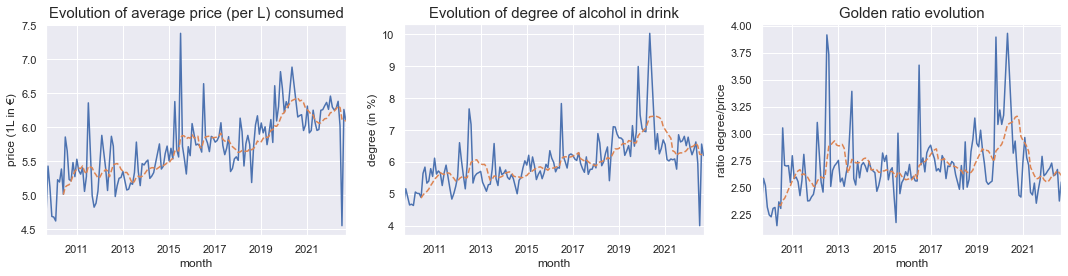

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

df_beer_purchase_agg = df_beer_purchase.groupby('month').agg({'degree': 'mean', 'ratio_price': 'mean', 'golden_ratio': 'mean'})

df_beer_purchase_agg['ratio_price'].plot(ax=ax1)
df_beer_purchase_agg['ratio_price'].rolling(10).mean().plot(linestyle='dashed', ax=ax1)
ax1.set_title('Evolution of average price (per L) consumed', fontsize = 15)
ax1.set_ylabel('price (1L in €)')

df_beer_purchase_agg['degree'].plot(ax=ax2)
df_beer_purchase_agg['degree'].rolling(10).mean().plot(linestyle='dashed', ax=ax2)
ax2.set_title('Evolution of degree of alcohol in drink', fontsize = 15)
ax2.set_ylabel('degree (in %)')


df_beer_purchase_agg['golden_ratio'].plot(ax=ax3)
df_beer_purchase_agg['golden_ratio'].rolling(10).mean().plot(linestyle='dashed', ax=ax3)
ax3.set_title('Golden ratio evolution', fontsize = 15)
ax3.set_ylabel('ratio degree/price')

plt.tight_layout()
plt.show()

### Graph analysis

In [127]:
df_beer_purchase_agg = df_beer_purchase.groupby('hour')['customer_id'].apply(set).apply(list)

In [128]:
df_beer_purchase_agg = df_beer_purchase_agg[df_beer_purchase_agg.str.len() > 1]

In [129]:
df_beer_purchase_agg

hour
2009-09-09 20:00                                           [109, 175]
2009-09-09 21:00                                           [217, 203]
2009-09-09 22:00                                   [43, 204, 85, 213]
2009-09-09 23:00                                       [240, 241, 43]
2009-09-10 01:00                                        [88, 43, 109]
                                          ...                        
2022-09-24 15:00                                         [1744, 1736]
2022-09-26 16:00                                         [1612, 1926]
2022-09-26 17:00     [1920, 2084, 2093, 1777, 1910, 1919, 1918, 1887]
2022-09-26 18:00    [2080, 2144, 2117, 2151, 1865, 2058, 2167, 207...
2022-09-26 19:00    [2080, 2112, 2084, 2151, 2059, 2060, 1910, 207...
Freq: H, Name: customer_id, Length: 8293, dtype: object

In [130]:
matrix = np.zeros((2183,2183))

for period in list(df_beer_purchase_agg[df_beer_purchase_agg.str.len() > 1]):
    for i in period:
        for j in period:
            matrix[i,j] +=1 
            
np.fill_diagonal(matrix, 0)

In [131]:
m = pd.DataFrame(matrix)
tmp = m.merge(df_customer.set_index('id'), left_index=True, right_index=True).drop(['status_id', 'year', 'is_bar'], axis=1).set_index('nickname').T
adj_matrix = tmp.merge(df_customer.set_index('id'), left_index=True, right_index=True).drop(['status_id', 'year', 'is_bar'], axis=1).set_index('nickname').T

In [132]:
# delete small connexions
for i in range(3):
    adj_matrix = adj_matrix.replace(i, 0)

In [145]:
lit_adj_matrix = adj_matrix.iloc[1650:1660,1650:1660]

In [146]:
lit_adj_matrix

nickname,bgettedu13,Marionette,camcam,Aymerrrric,Dada,Toto Levy,cle,coco22,cleo,Marine
bgettedu13,0.0,33.0,15.0,0.0,0.0,0.0,3.0,4.0,11.0,12.0
Marionette,33.0,0.0,25.0,0.0,0.0,0.0,3.0,5.0,5.0,20.0
camcam,15.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
Aymerrrric,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,6.0,3.0
Dada,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,4.0,4.0
Toto Levy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cle,3.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,3.0
coco22,4.0,5.0,0.0,4.0,4.0,0.0,4.0,0.0,4.0,5.0
cleo,11.0,5.0,0.0,6.0,4.0,0.0,4.0,4.0,0.0,9.0
Marine,12.0,20.0,4.0,3.0,4.0,0.0,3.0,5.0,9.0,0.0


In [135]:
adj_matrix.to_csv('matrix.csv')
lit_adj_matrix.to_csv('little_matrix.csv')

<AxesSubplot:>

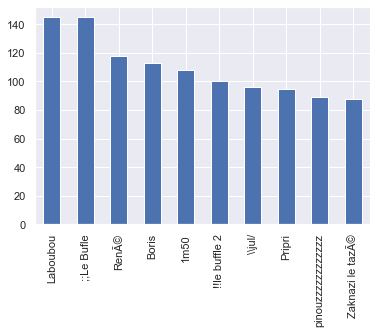

In [141]:
adj_matrix.__relouvet__.sort_values(ascending=False)[:10].plot(kind='bar')

<AxesSubplot:>

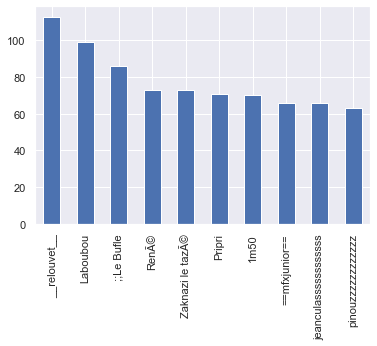

In [142]:
adj_matrix.Boris.sort_values(ascending=False)[:10].plot(kind='bar')